# Demo on Training GCN Surrogate Model from Scratch

###  Introduction
This notebook demonstrates how to train a Graph Convolutional Network (GCN) for performance of parametrized quantum circuits (PQCs). 
The circuits are first converted into **directed acyclic graphs (DAGs)** that capture structural and gate-based information.

### Imports and Setup

First, we suppress PyTorch Warnings and ensure proper dependency loading. Then, we import core modules and helper functions from our project structure.

In [1]:
# Suppress PyTorch Warnings and ensure proper dependency loading
import warnings
import os
import sys

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..')) # Go two levels up from the notebook location to reach project root

if project_root not in sys.path:
    sys.path.insert(0, project_root)
print("Project root set to:", project_root)

Project root set to: C:\SQuASH


In [2]:
import os
import json
import torch
import torch.nn as nn
from datetime import datetime

from config import get_default_model_config_by_search_space, PathConfig
from surrogate_models.prepare_dataset.gen_dataset import create_gcn_data
from surrogate_models.architectures.gnn.gnn_model import RegGNN
from surrogate_models.architectures.gnn.gcn_runner import set_seed, prepare_paths_and_config, prepare_dataset, prepare_dataloaders, save_json, train, save_results, plot_metrics
from util.data_loader import load_data, save_data
from util.config_utils import get_gate_set_and_features_by_name
from util import split
from torch_geometric.loader import DataLoader

### 📁 Step 1: Prepare Paths and Configuration

The configuration for the surrogate model is defined and loaded in two stages: 
 - setting the search space and device
 - specify config for the surrogate model

In [3]:
search_space = 'ghz_a'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

This sets the quantum circuit benchmark domain (search_space) and selects the device (cpu or cuda) for training.

In [4]:
config, gate_set, timestamp = prepare_paths_and_config(search_space, device)
print("Config (incl. model config):")
print(json.dumps(config, indent=4, default=str))

config["epochs"] = 40 # set the max.number of training epochs to 4

Config (incl. model config):
{
    "device": "cpu",
    "seed": 42,
    "runseed": 42,
    "batch_size": 32,
    "num_workers": 0,
    "epochs": 3,
    "emb_dim": 1200,
    "layer_num": 8,
    "qubit_num": 3,
    "num_node_features": 7,
    "drop_ratio": 0.012714767230404513,
    "lr": 0.00042048670814195114,
    "decay": 1.2239395743425164e-06,
    "JK": "mean",
    "patience": 7,
    "metric": "spearman",
    "graph_pooling": "max",
    "n_estimators": null,
    "max_depth": null,
    "random_state": null,
    "optuna_trials": null,
    "min_samples_split": null,
    "min_samples_leaf": null,
    "max_features": null,
    "n_jobs": null,
    "PATHS": {
        "optuna_studies": "C:\\SQuASH\\surrogate_models/tuning\\studies",
        "raw_data": "C:\\SQuASH\\data/raw_data/",
        "gcn_data": "C:\\SQuASH\\data/processed_data/gcn_processed_data",
        "rf_data": "C:\\SQuASH\\data\\rf_data",
        "trained_models": "C:\\SQuASH\\surrogate_models\\trained_models",
        "benchmar

#### ⚙️ Model Configuration: How It Works

The function `prepare_paths_and_config()` in  
`surrogate_models.architectures.gnn.gcn_runner` is responsible for initializing model parameters and file paths.  
It internally calls:

```python
model_config = get_default_model_config_by_search_space(
    model_type="gcn",
    search_space=search_space,
    features=features,
    device=device
)
```
This function is defined in `config.py` and retrieves a predefined set of hyperparameters based on the model type (e.g., `"gcn"`) and benchmark search space (e.g., `"ghz_a"`)

**Fallback Mechanism**  
If no external `JSON` config is available, the method falls back to the hardcoded default in `_get_default_model_config()` (also in `config.py`).  
Example: Default GCN Config for `ghz_a`:
```python
{
    'emb_dim': 1200,                 # Hidden embedding dimension
    'layer_num': 8,                  # Number of GNN layers
    'qubit_num': 3,                  # Number of qubits (used for metadata/consistency)
    'num_node_features': features,  # Input feature dimension (from dataset)
    'drop_ratio': 0.0127,            # Dropout probability
    'batch_size': 32,                # Training batch size
    'epochs': 3,                     # Max training epochs (early stopping may stop earlier)
    'lr': 0.00042,                   # Learning rate
    'decay': 1.22e-6,                # Weight decay (L2 regularization)
    'JK': 'mean',                    # Jumping Knowledge aggregation strategy
    'graph_pooling': 'max',          # Graph-level pooling method
    'metric': 'spearman',            # Evaluation metric (e.g., for ranking correlation)
    
    # Additional global settings added later
    'device': device,                # Either 'cpu' or 'cuda'
    'seed': 42,                      # Random seed for reproducibility
    'runseed': 42,                   # Secondary run seed
    'num_workers': 0,                # Dataloader parallelism (set 0 for CPU)
    'patience': 7                    # Early stopping patience
}
```

**Flexible Configuration**  
This dictionary-style configuration allows for easy, dynamic updates during runtime.
For example, to change the number of training epochs:

```python
config["epochs"] = 30
```

This sets the maximum number of training epochs.
Note: early stopping can still terminate training earlier, based on the configured patience and validation performance.

### 🔧 Step 2: Set Random Seed

For reproducibility, it's important to set all random seeds.

In [5]:
set_seed(config["runseed"])

### 📦 Step 3: Load or Generate Dataset

To be processed by GCN, the data—i.e. quantum circuits—need to be transformed into DAGs. If preprocessed data is not found, it's automatically created from raw quantum circuit files.

In [6]:
data_name = f"demo_dataset_ghz_a"
data_path = os.path.join(config['PATHS']['gcn_data'], f'{data_name}.pt')
train_data, val_data, test_data = prepare_dataset(data_name, data_path, gate_set, search_space, config, timestamp)

[INFO] GCN data not found. Generating from raw circuits...
Successfully saved to C:\SQuASH\data/processed_data/gcn_processed_data\demo_dataset_ghz_a.pt: 18378 items
[INFO] Train: 14702, Val: 2756, Test: 920
Successfully saved to C:\SQuASH\data/processed_data/gcn_processed_data\test_gcn_ghz_a_2025-04-19_15-14-17.pt: 920 items


### 🧪 Step 4: Prepare DataLoaders

We use PyTorch Geometric's `DataLoader` to batch and feed our graph data efficiently into the GCN.

In [7]:
train_loader, val_loader, test_loader = prepare_dataloaders(
    train_data, val_data, test_data,
    batch_size=config['batch_size'],
    num_workers=config['num_workers']
)

### 📝 Step 5: Save Model Configuration

We persist the configuration used for this training session for reproducibility.


In [8]:
model_name = f"demo_gcn_{search_space}_{timestamp}"
model_logs_path = os.path.join(config['PATHS'][f'trained_models'], f'{model_name}')
os.makedirs(model_logs_path, exist_ok=True)
save_json(os.path.join(model_logs_path, f'{model_name}_config.json'), config)

### 🚀 Step 6: Train the GCN Model
We train a `RegGNN` model for a fixed number of epochs. The best model is selected based on validation performance using Spearman's rho (or MSE or R2).

In [9]:
print("[INFO] Starting training")
results, loss_records = train(model_name, config, train_loader, val_loader, test_loader, nn.MSELoss(), model_logs_path)

[INFO] Starting training
Device: cpu

Epoch 1/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.36it/s]


Train Loss: 0.1157, Validation Loss: 0.0180
Train Spearman: 0.3552, Validation Spearman: 0.6446
[INFO] Best model saved to C:\SQuASH\surrogate_models\trained_models\demo_gcn_ghz_a_2025-04-19_15-14-17\demo_gcn_ghz_a_2025-04-19_15-14-17.pth

Epoch 2/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.56it/s]


Train Loss: 0.0170, Validation Loss: 0.0138
Train Spearman: 0.6442, Validation Spearman: 0.6644
[INFO] Best model saved to C:\SQuASH\surrogate_models\trained_models\demo_gcn_ghz_a_2025-04-19_15-14-17\demo_gcn_ghz_a_2025-04-19_15-14-17.pth

Epoch 3/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:07<00:00, 11.69it/s]


Train Loss: 0.0156, Validation Loss: 0.0136
Train Spearman: 0.6739, Validation Spearman: 0.6602

Epoch 4/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:09<00:00,  9.23it/s]


Train Loss: 0.0147, Validation Loss: 0.0241
Train Spearman: 0.6959, Validation Spearman: 0.6181
[INFO] Overfitting detected (1/5)

Epoch 5/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:09<00:00,  9.38it/s]


Train Loss: 0.0149, Validation Loss: 0.0142
Train Spearman: 0.6900, Validation Spearman: 0.7134
[INFO] Best model saved to C:\SQuASH\surrogate_models\trained_models\demo_gcn_ghz_a_2025-04-19_15-14-17\demo_gcn_ghz_a_2025-04-19_15-14-17.pth

Epoch 6/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:09<00:00,  8.73it/s]


Train Loss: 0.0141, Validation Loss: 0.0135
Train Spearman: 0.7076, Validation Spearman: 0.6843

Epoch 7/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:09<00:00,  9.34it/s]


Train Loss: 0.0147, Validation Loss: 0.0123
Train Spearman: 0.6976, Validation Spearman: 0.7353
[INFO] Best model saved to C:\SQuASH\surrogate_models\trained_models\demo_gcn_ghz_a_2025-04-19_15-14-17\demo_gcn_ghz_a_2025-04-19_15-14-17.pth

Epoch 8/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:10<00:00,  8.53it/s]


Train Loss: 0.0139, Validation Loss: 0.0130
Train Spearman: 0.7116, Validation Spearman: 0.7214
[INFO] Overfitting detected (1/5)

Epoch 9/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:09<00:00,  8.89it/s]


Train Loss: 0.0137, Validation Loss: 0.0114
Train Spearman: 0.7140, Validation Spearman: 0.7099

Epoch 10/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:09<00:00,  8.88it/s]


Train Loss: 0.0131, Validation Loss: 0.0106
Train Spearman: 0.7171, Validation Spearman: 0.7609
[INFO] Best model saved to C:\SQuASH\surrogate_models\trained_models\demo_gcn_ghz_a_2025-04-19_15-14-17\demo_gcn_ghz_a_2025-04-19_15-14-17.pth

Epoch 11/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:09<00:00,  9.44it/s]


Train Loss: 0.0124, Validation Loss: 0.0119
Train Spearman: 0.7320, Validation Spearman: 0.7382
[INFO] Overfitting detected (1/5)

Epoch 12/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:09<00:00,  9.10it/s]


Train Loss: 0.0112, Validation Loss: 0.0125
Train Spearman: 0.7495, Validation Spearman: 0.7542
[INFO] Overfitting detected (2/5)

Epoch 13/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:08<00:00, 10.01it/s]


Train Loss: 0.0109, Validation Loss: 0.0112
Train Spearman: 0.7520, Validation Spearman: 0.7377

Epoch 14/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:09<00:00,  9.26it/s]


Train Loss: 0.0104, Validation Loss: 0.0156
Train Spearman: 0.7599, Validation Spearman: 0.7402
[INFO] Overfitting detected (1/5)

Epoch 15/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:10<00:00,  8.19it/s]


Train Loss: 0.0101, Validation Loss: 0.0112
Train Spearman: 0.7621, Validation Spearman: 0.7523

Epoch 16/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:12<00:00,  7.16it/s]


Train Loss: 0.0095, Validation Loss: 0.0104
Train Spearman: 0.7697, Validation Spearman: 0.7495

Epoch 17/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:14<00:00,  6.19it/s]


Train Loss: 0.0090, Validation Loss: 0.0118
Train Spearman: 0.7755, Validation Spearman: 0.7623
[INFO] Best model saved to C:\SQuASH\surrogate_models\trained_models\demo_gcn_ghz_a_2025-04-19_15-14-17\demo_gcn_ghz_a_2025-04-19_15-14-17.pth
[INFO] Overfitting detected (1/5)

Epoch 18/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:12<00:00,  6.95it/s]


Train Loss: 0.0080, Validation Loss: 0.0123
Train Spearman: 0.7868, Validation Spearman: 0.7448
[INFO] Overfitting detected (2/5)

Epoch 19/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:08<00:00, 10.11it/s]


Train Loss: 0.0077, Validation Loss: 0.0097
Train Spearman: 0.7882, Validation Spearman: 0.7675
[INFO] Best model saved to C:\SQuASH\surrogate_models\trained_models\demo_gcn_ghz_a_2025-04-19_15-14-17\demo_gcn_ghz_a_2025-04-19_15-14-17.pth

Epoch 20/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:08<00:00, 10.10it/s]


Train Loss: 0.0073, Validation Loss: 0.0095
Train Spearman: 0.7948, Validation Spearman: 0.7617

Epoch 21/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:10<00:00,  8.44it/s]


Train Loss: 0.0071, Validation Loss: 0.0155
Train Spearman: 0.7981, Validation Spearman: 0.7709
[INFO] Best model saved to C:\SQuASH\surrogate_models\trained_models\demo_gcn_ghz_a_2025-04-19_15-14-17\demo_gcn_ghz_a_2025-04-19_15-14-17.pth
[INFO] Overfitting detected (1/5)

Epoch 22/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:11<00:00,  7.73it/s]


Train Loss: 0.0064, Validation Loss: 0.0132
Train Spearman: 0.8038, Validation Spearman: 0.7695

Epoch 23/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:10<00:00,  8.02it/s]


Train Loss: 0.0060, Validation Loss: 0.0083
Train Spearman: 0.8083, Validation Spearman: 0.7806
[INFO] Best model saved to C:\SQuASH\surrogate_models\trained_models\demo_gcn_ghz_a_2025-04-19_15-14-17\demo_gcn_ghz_a_2025-04-19_15-14-17.pth

Epoch 24/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:12<00:00,  6.89it/s]


Train Loss: 0.0060, Validation Loss: 0.0077
Train Spearman: 0.8091, Validation Spearman: 0.7881
[INFO] Best model saved to C:\SQuASH\surrogate_models\trained_models\demo_gcn_ghz_a_2025-04-19_15-14-17\demo_gcn_ghz_a_2025-04-19_15-14-17.pth

Epoch 25/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:08<00:00,  9.78it/s]


Train Loss: 0.0052, Validation Loss: 0.0101
Train Spearman: 0.8154, Validation Spearman: 0.7804
[INFO] Overfitting detected (1/5)

Epoch 26/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:09<00:00,  9.45it/s]


Train Loss: 0.0051, Validation Loss: 0.0101
Train Spearman: 0.8167, Validation Spearman: 0.7653

Epoch 27/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:08<00:00, 10.08it/s]


Train Loss: 0.0048, Validation Loss: 0.0080
Train Spearman: 0.8204, Validation Spearman: 0.7787

Epoch 28/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:08<00:00,  9.71it/s]


Train Loss: 0.0048, Validation Loss: 0.0088
Train Spearman: 0.8198, Validation Spearman: 0.7749
[INFO] Overfitting detected (1/5)

Epoch 29/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:09<00:00,  8.99it/s]


Train Loss: 0.0042, Validation Loss: 0.0079
Train Spearman: 0.8251, Validation Spearman: 0.7902
[INFO] Best model saved to C:\SQuASH\surrogate_models\trained_models\demo_gcn_ghz_a_2025-04-19_15-14-17\demo_gcn_ghz_a_2025-04-19_15-14-17.pth

Epoch 30/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:09<00:00,  9.26it/s]


Train Loss: 0.0041, Validation Loss: 0.0083
Train Spearman: 0.8276, Validation Spearman: 0.7825
[INFO] Overfitting detected (1/5)

Epoch 31/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:09<00:00,  9.32it/s]


Train Loss: 0.0041, Validation Loss: 0.0083
Train Spearman: 0.8269, Validation Spearman: 0.7827

Epoch 32/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:09<00:00,  9.05it/s]


Train Loss: 0.0039, Validation Loss: 0.0097
Train Spearman: 0.8290, Validation Spearman: 0.7609
[INFO] Overfitting detected (1/5)

Epoch 33/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:09<00:00,  8.93it/s]


Train Loss: 0.0037, Validation Loss: 0.0086
Train Spearman: 0.8311, Validation Spearman: 0.7696

Epoch 34/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:10<00:00,  8.50it/s]


Train Loss: 0.0031, Validation Loss: 0.0078
Train Spearman: 0.8358, Validation Spearman: 0.7909
[INFO] Best model saved to C:\SQuASH\surrogate_models\trained_models\demo_gcn_ghz_a_2025-04-19_15-14-17\demo_gcn_ghz_a_2025-04-19_15-14-17.pth

Epoch 35/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:09<00:00,  8.91it/s]


Train Loss: 0.0030, Validation Loss: 0.0082
Train Spearman: 0.8355, Validation Spearman: 0.7869
[INFO] Overfitting detected (1/5)

Epoch 36/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:10<00:00,  8.57it/s]


Train Loss: 0.0034, Validation Loss: 0.0075
Train Spearman: 0.8329, Validation Spearman: 0.7898

Epoch 37/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:10<00:00,  8.43it/s]


Train Loss: 0.0029, Validation Loss: 0.0080
Train Spearman: 0.8373, Validation Spearman: 0.7814
[INFO] Overfitting detected (1/5)

Epoch 38/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:10<00:00,  8.14it/s]


Train Loss: 0.0029, Validation Loss: 0.0078
Train Spearman: 0.8373, Validation Spearman: 0.7858

Epoch 39/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:10<00:00,  8.36it/s]


Train Loss: 0.0027, Validation Loss: 0.0079
Train Spearman: 0.8376, Validation Spearman: 0.7843
[INFO] Overfitting detected (1/5)

Epoch 40/40


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:11<00:00,  7.85it/s]


Train Loss: 0.0025, Validation Loss: 0.0078
Train Spearman: 0.8383, Validation Spearman: 0.7853


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:02<00:00,  9.80it/s]


Test Loss: 0.0084, Spearman: 0.7929, R2: 0.6934


### 📊 Step 7: Evaluate Model Performance

We inspect the best achieved validation metric and performance on the test set.


In [10]:
for model_name, best_val, test_loss, test_spear, test_r2 in results:
    print(
        f"\nModel: {model_name} | Best Val: {best_val:.4f} | Test Loss: {test_loss:.4f} | Spearman: {test_spear:.4f} | R2: {test_r2:.4f}")


Model: demo_gcn_ghz_a_2025-04-19_15-14-17 | Best Val: 0.7909 | Test Loss: 0.0084 | Spearman: 0.7929 | R2: 0.6934


### 💾 Step 8: Save Results

Benchmark and training records are stored as pickle files.

In [11]:
save_results(results, loss_records, search_space, model_logs_path)

### 📈 Step 9: Plot Training Metrics

Loss and Spearman's rho are plotted over epochs to visualize training dynamics.

[INFO] Loss plot is saved to C:\SQuASH\surrogate_models\trained_models\demo_gcn_ghz_a_2025-04-19_15-14-17\demo_gcn_ghz_a_2025-04-19_15-14-17_loss.png


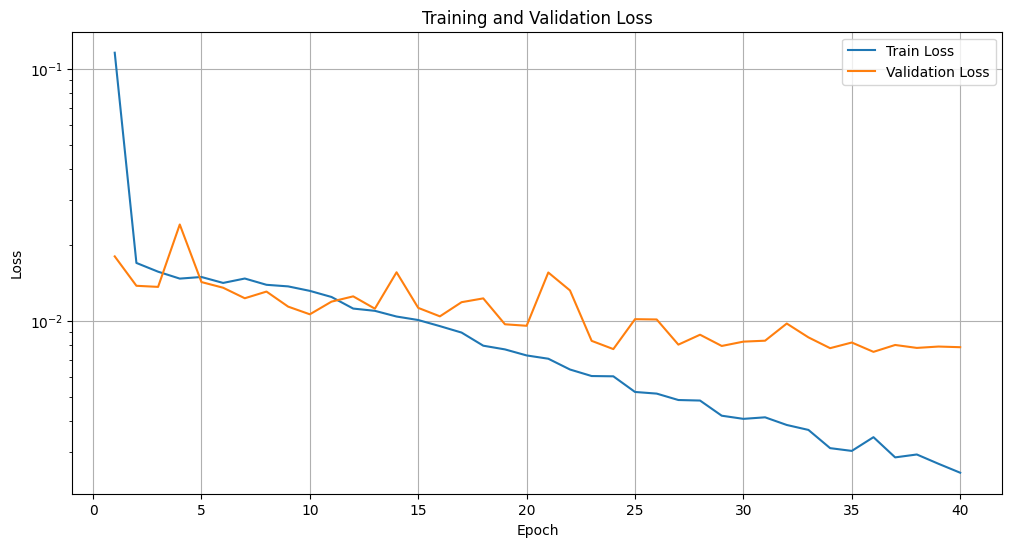

[INFO] Spearman's rho plot is saved to C:\SQuASH\surrogate_models\trained_models\demo_gcn_ghz_a_2025-04-19_15-14-17\demo_gcn_ghz_a_2025-04-19_15-14-17_spearman.png


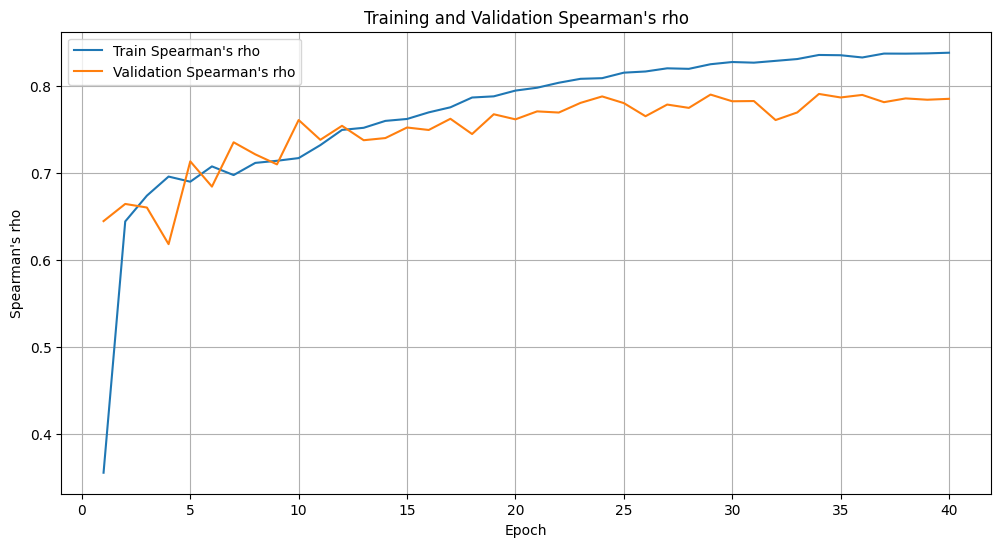

In [12]:
epochs = range(1, len(loss_records[model_name]['train_losses']) + 1)
file_path_loss_plot = os.path.join(model_logs_path, f'{model_name}_loss.png')
file_path_spearman_plot = os.path.join(model_logs_path, f'{model_name}_spearman.png')
plot_metrics(file_path_loss_plot, epochs, loss_records[model_name], 'losses', 'Loss', 'Training and Validation Loss')
plot_metrics(file_path_spearman_plot, epochs, loss_records[model_name], 'spearmans', "Spearman's rho", "Training and Validation Spearman's rho")